In [1]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

#Import standard libraries
import numpy as np
import time
import seaborn as sns
import pandas as pd
from itertools import product

from scipy.interpolate import interp1d
from scipy.integrate import simps as simps
from scipy.integrate import cumtrapz as cumtrapz
from scipy.integrate import simps, solve_ivp
from scipy.constants import c as c_light #meters/seconds
from scipy.stats.distributions import chi2 as chi2_dist

c_light_km = c_light/1000 #km/s

import getdist
getdist.chains.print_load_details = False

# import repo functions:
import sys, os
import os
import git
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
#path_data = os.path.join(os.path.dirname(path_git), 'GILA-output', 'paper', 'ULTIMA COSA', 'GILA')
path_data = os.path.join(os.path.dirname(path_git), 'GILA-output', 'paper')
path_figures = os.path.join(path_git, 'notebooks', 'figures')

os.chdir(os.path.join(path_git, 'fr_mcmc', 'utils'))
from supernovae import aparent_magnitude_th, chi2_supernovae
from constants import OMEGA_R_0, LAMBDA, L, KAPPA

In [2]:
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
os.chdir(path_git); os.sys.path.append('./fr_mcmc/utils/')
from data import read_data_chronometers, read_data_pantheon_plus_shoes

# Cosmic Chronometers
os.chdir(path_git+'/fr_mcmc/source/CC/')
ds_CC = read_data_chronometers('chronometers_data.txt')

# Pantheon plus + SH0ES
os.chdir(path_git+'/fr_mcmc/source/Pantheon_plus_shoes')
ds_SN_plus_shoes = read_data_pantheon_plus_shoes('Pantheon+SH0ES.dat',
                                'Pantheon+SH0ES_STAT+SYS.cov')


First, let's fix some parameters

In [3]:
#Fix params
L_bar = 0.90

num_free_parameters = 3
dof = ds_SN_plus_shoes[2].shape[0]+len(ds_CC[0]) - num_free_parameters

confidence_level = 0.683 #1 sigma contour
#confidence_level = 0.954 #2 sigma contour
#confidence_level = 0.997 #3 sigma contour


In [4]:
from scipy.stats import chi2

def chi2_threshold(N, p, confidence):
    """
    Compute the chi-square threshold for model rejection based on a given confidence level.
    
    Parameters:
    N (int): Number of data points
    p (int): Number of parameters
    confidence (float): Confidence level (e.g., 0.95 for 95%)
    
    Returns:
    float: Reduced chi-square threshold
    """
    nu = N - p  # Degrees of freedom
    chi2_crit = chi2.ppf(confidence, df=nu)  # Critical chi-square value
    return chi2_crit / nu  # Convert to reduced chi-square

# Example usage
N = ds_SN_plus_shoes[2].shape[0]+len(ds_CC[0])
p = 3
confidence_level = 0.683  # 68.3% confidence threshold

chi2_th = chi2_threshold(N, p, confidence_level)
print(f"Reduced chi-square threshold for {confidence_level*100}% confidence: {chi2_th:.5f}")
print(1+np.sqrt(2/(N-p)))


Reduced chi-square threshold for 68.30000000000001% confidence: 1.01610
1.0344622758397788


# GILA model analysis

In [5]:
#GILA MODEL
#r_min = 3
#s_min = 1

model = 'GILA'
#H0_values = np.linspace(60,80,20)[::-1] 
#beta_values = np.linspace(0.1,12,20)
#Mabs_values = np.linspace(-21,-18.5,20)

#H0_values = np.linspace(60,80,100)[::-1] 
#beta_values = np.linspace(0.1,12,100)
#Mabs_values = np.linspace(-21,-18.5,100)
H0_values = np.linspace(60,80,50)[::-1] 
beta_values = np.linspace(0.1,12,50)
Mabs_values = np.linspace(-21,-18.5,50)
print(H0_values, beta_values, Mabs_values)

#r = 3; s = 4 
r = 3; s = 5 
#r = 3; s = 6 

#matrix_gila_chi2 = np.load(os.path.join(path_data, 'matrix_chi2_{0}_r={1}_s={2}.npy'.format(model, r, s)))
#matrix_gila_aou = np.load(os.path.join(path_data, 'matrix_aou_{0}_r={1}_s={2}.npy'.format(model, r, s)))

matrix_gila_chi2 = np.load(os.path.join(path_data, 'matrix_chi2_{0}_r={1}_s={2}_50.npy'.format(model, r, s)))
matrix_gila_aou = np.load(os.path.join(path_data, 'matrix_aou_{0}_r={1}_s={2}_50.npy'.format(model, r, s)))


[80.         79.59183673 79.18367347 78.7755102  78.36734694 77.95918367
 77.55102041 77.14285714 76.73469388 76.32653061 75.91836735 75.51020408
 75.10204082 74.69387755 74.28571429 73.87755102 73.46938776 73.06122449
 72.65306122 72.24489796 71.83673469 71.42857143 71.02040816 70.6122449
 70.20408163 69.79591837 69.3877551  68.97959184 68.57142857 68.16326531
 67.75510204 67.34693878 66.93877551 66.53061224 66.12244898 65.71428571
 65.30612245 64.89795918 64.48979592 64.08163265 63.67346939 63.26530612
 62.85714286 62.44897959 62.04081633 61.63265306 61.2244898  60.81632653
 60.40816327 60.        ] [ 0.1         0.34285714  0.58571429  0.82857143  1.07142857  1.31428571
  1.55714286  1.8         2.04285714  2.28571429  2.52857143  2.77142857
  3.01428571  3.25714286  3.5         3.74285714  3.98571429  4.22857143
  4.47142857  4.71428571  4.95714286  5.2         5.44285714  5.68571429
  5.92857143  6.17142857  6.41428571  6.65714286  6.9         7.14285714
  7.38571429  7.62857143  

In [6]:
print(matrix_gila_chi2.shape)

(50, 50, 50)


### Important questions

In [37]:
aou_threshold = 14
#aou_threshold = 12
#aou_threshold = 12.7

chi2_th = chi2_threshold(N, p, confidence_level)
print('Aou threhold: {}'.format(aou_threshold))
print('chi2 threhold: {}'.format(chi2_th))

masked_data_with_aou = np.where(matrix_gila_aou >= aou_threshold, matrix_gila_chi2, np.nan)

print('Has integration issues?: {}'.format(np.all(np.isnan(matrix_gila_chi2)))) #should be False
print('Has issues when Aou cut-off is applied?: {}'.format(np.all(np.isnan(masked_data_with_aou))))#should be False
print('chi2_min<=chi2_threshold?: {}'.format(np.nanmin(masked_data_with_aou)/dof<=chi2_th))#should be True


Aou threhold: 15
chi2 threhold: 1.0160978536321694
Has integration issues?: False
Has issues when Aou cut-off is applied?: False
chi2_min<=chi2_threshold?: False


In [34]:
print(r'Minimum of the reduced $\chi^2$:{}'.format(np.nanmin(masked_data_with_aou)/dof))

#Double check
where_global_min = np.where(masked_data_with_aou==np.nanmin(masked_data_with_aou))
masked_data_with_aou[where_global_min]/dof

Minimum of the reduced $\chi^2$:0.9568746997847244


array([0.9568747])

In [35]:
masked_data_with_aou = np.where(matrix_gila_aou >= aou_threshold, matrix_gila_chi2, np.nan)
masked_data_with_1_sigma = np.where(matrix_gila_chi2/dof <= chi2_th, matrix_gila_chi2, np.nan)
masked_data_with_aou_1_sigma = np.where(matrix_gila_chi2/dof <= chi2_th, masked_data_with_aou, np.nan)

print(masked_data_with_aou)
print(masked_data_with_1_sigma)
print(masked_data_with_aou_1_sigma)

[[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 ...

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan n

# 3D Monte Carlo sampling

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
(50, 50, 5

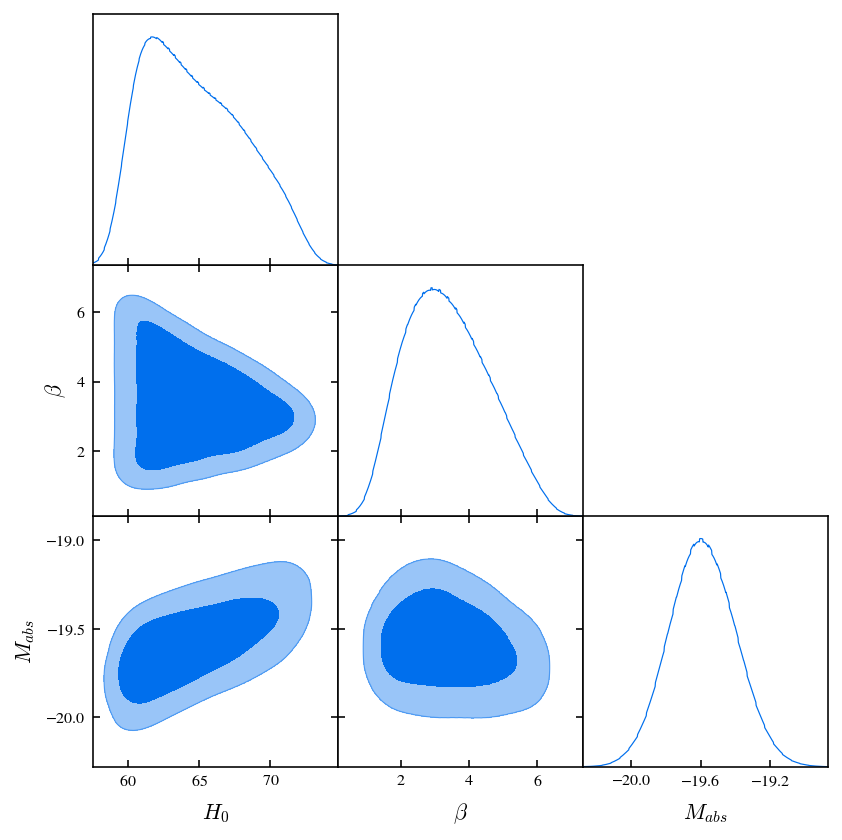

In [36]:
import getdist
import getdist.plots as gdplt
%matplotlib inline

x_vals = H0_values 
y_vals = beta_values 
z_vals = Mabs_values
#matrix_gila_chi2 = np.load(os.path.join(path_data, 'matrix_gila_chi2.npy'))

#aux = matrix_gila_chi2.copy()/np.nanmin(matrix_gila_chi2)
#aux[np.isnan(matrix_gila_chi2)]=np.inf

aux = masked_data_with_aou.copy()/np.nanmin(masked_data_with_aou)
aux[np.isnan(masked_data_with_aou)]=np.inf

p3d = np.exp(-aux/2)

# Normalize the distribution
p3d /= np.sum(p3d)
print(p3d)
print(p3d.shape)
# Convert 3D posterior into samples
flattened_probs = p3d.flatten()
grid_points = np.array(np.meshgrid(x_vals, y_vals, z_vals, indexing='ij')).reshape(3, -1).T

# Sample points from the distribution
num_samples = int(1e5)  # Number of samples you want
sample_indices = np.random.choice(len(flattened_probs), size=num_samples, p=flattened_probs)
samples = grid_points[sample_indices]

samples_1 = samples.copy()



# Convert to GetDist format
gd_samples = getdist.mcsamples.MCSamples(samples=samples, names=['x', 'y', 'z'],
                                         labels=[r'H_0', r'\beta', r'M_{abs}'],
                                         settings={'mult_bias_correction_order':0,
                                                   'smooth_scale_2D':0.3,
                                                   'smooth_scale_1D':0.3}
                                         )

# Plot using GetDist
g = gdplt.get_subplot_plotter()
g.triangle_plot([gd_samples], filled=True)
g.export(path_git+'triangle_gila_plot.pdf')
plt.show()

67.32704489795918
3.7217237142857136
-19.497718877551023


(array([   72.,   954.,  6278., 17830., 26408., 31310., 12239.,  4156.,
          697.,    56.]),
 array([-20.28571429, -20.12244898, -19.95918367, -19.79591837,
        -19.63265306, -19.46938776, -19.30612245, -19.14285714,
        -18.97959184, -18.81632653, -18.65306122]),
 <a list of 10 Patch objects>)

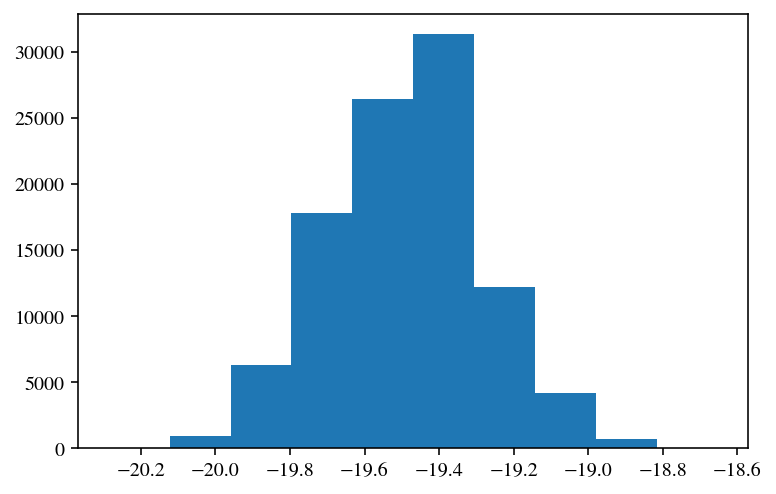

In [11]:
print(np.mean(samples[:,0]))
print(np.mean(samples[:,1]))
print(np.mean(samples[:,2]))
plt.hist(samples[:,2])

## 2D proyection

In [12]:
print(r'The global minima corresponds to M abs={0}'.format(Mabs_values[where_global_min[2][0]]))
matrix_gila_chi2_2d = matrix_gila_chi2[:,:,where_global_min[2][0]]/dof
masked_data_with_aou_2d = masked_data_with_aou[:,:,where_global_min[2][0]]/dof
masked_data_with_1_sigma_2d = masked_data_with_1_sigma[:,:,where_global_min[2][0]]/dof
masked_data_with_aou_1_sigma_2d = masked_data_with_aou_1_sigma[:,:,where_global_min[2][0]]/dof

The global minima corresponds to M abs=-19.367346938775512


In [13]:
matrix_gila_chi2_2d = np.zeros((len(beta_values),len(H0_values)))
for i in range(len(beta_values)):
    for j in range(len(H0_values)):
        matrix_gila_chi2_2d[i,j] = matrix_gila_chi2[i,j,np.where(matrix_gila_chi2[i,j,:]==np.nanmin(matrix_gila_chi2[i,j,:]))[0][0]]


/home/mleize/miniconda3/envs/fR-MCMC/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


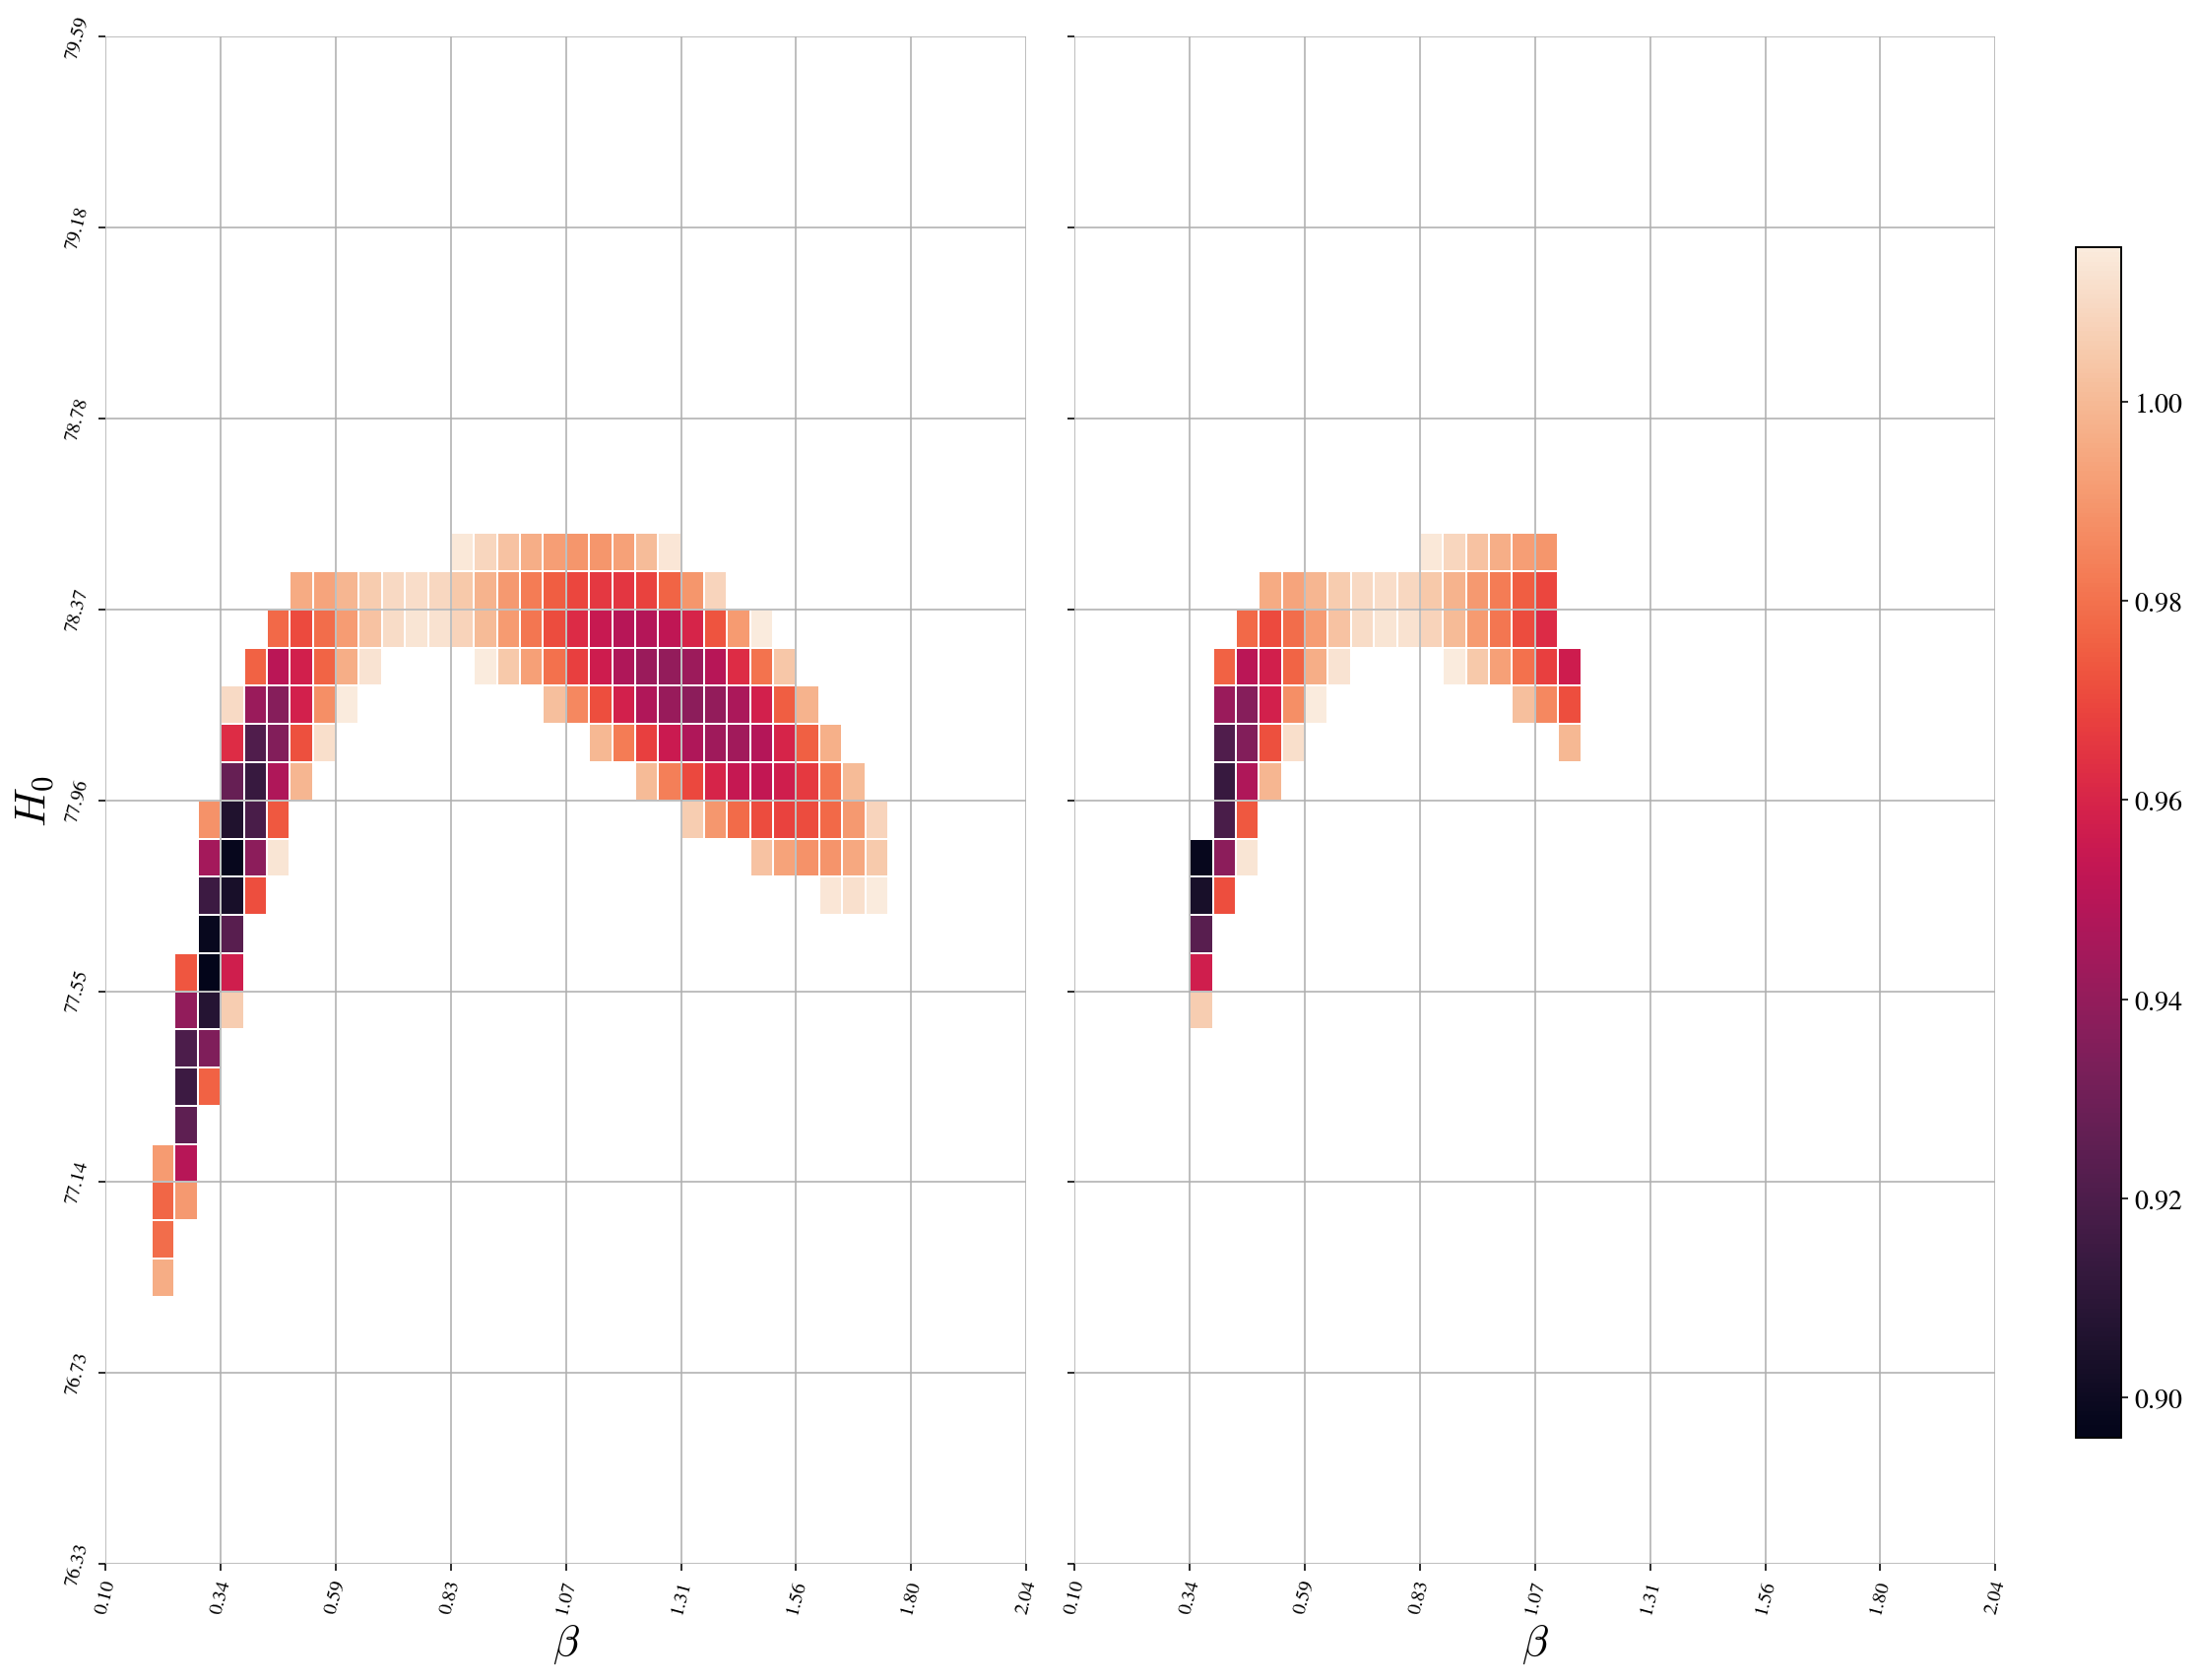

In [14]:
# Plot GILA model
fig, axes = plt.subplots(1,2,figsize=(16, 12))
# Define common color scale
vmin = min(np.nanmin(masked_data_with_1_sigma_2d), np.nanmin(masked_data_with_aou_1_sigma_2d))
vmax = max(np.nanmax(masked_data_with_1_sigma_2d), np.nanmax(masked_data_with_aou_1_sigma_2d))

# Plot heatmaps without colorbars
sns.heatmap(masked_data_with_1_sigma_2d, ax=axes[0], linewidth=0.5, vmin=vmin, vmax=vmax, cbar=False)
sns.heatmap(masked_data_with_aou_1_sigma_2d, ax=axes[1], linewidth=0.5, vmin=vmin, vmax=vmax, cbar=False)

tick_beta = np.arange(0,len(beta_values),5)
tick_H0 = np.arange(0,len(H0_values),5)
# General configurations for all axes
for ax in axes.flat:
    ax.set_xlabel(r'$\beta$', fontsize=22)
    ax.set_ylabel(r'$H_0$', fontsize=22)

    ax.set_xticks(tick_beta)
    ax.set_yticks(tick_H0)
    ax.set_xticklabels([f'{tick:.2f}' for tick in beta_values[::1]],rotation = 75)
    ax.set_yticklabels([f'{tick:.2f}' for tick in H0_values[::1]],rotation = 75)

    ax.label_outer()
    ax.grid()
    
    ax.set_xlim(0, 40)
    ax.set_ylim(45, 5)



#H0_values = np.linspace(60,80,50)[::-1] 
#beta_values = np.linspace(0.1,12,50)
#Mabs_values = np.linspace(-21,-18.5,50)

# Add a single colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust position as needed
cbar = fig.colorbar(axes[0].collections[0], cax=cbar_ax)  # Use one of the heatmap's color mappings

# Change colorbar tick label size
cbar.ax.tick_params(labelsize=14)  # Set fontsize


fig.colorbar(axes[0].collections[0], cax=cbar_ax)  # Use one of the heatmap's color mappings

fig.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit the colorbar


fig.savefig(os.path.join(path_figures, 'heat_map_aou_GILA_r={0}_s={1}_Lbar={2}.png'.format(r,s,L_bar)))
fig.savefig(os.path.join(path_figures, 'heat_map_aou_GILA_r={0}_s={1}_Lbar={2}.pdf'.format(r,s,L_bar)))
plt.show()



In [78]:
np.arange(0,len(beta_values),2)

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 40, 42, 44, 46, 48])

# Confidence intervals 

In [16]:
print('GILA model')
print('Exponents: r = {0}, s = {1}'.format(r,s))
print(r'M abs: {0:3f} \pm {1:3f}'.format(np.mean(samples[:,2]), np.std(samples[:,2])))
print(r'H0: {0:3f} \pm {1:3f}'.format(np.mean(samples[:,0]), np.std(samples[:,0])))
print(r'$\beta$: {0:3f} \pm {1:3f}'.format(np.mean(samples[:,1]), np.std(samples[:,1])))


GILA model
Exponents: r = 3, s = 5
M abs: -19.497719 \pm 0.212366
H0: 67.327045 \pm 5.157981
$\beta$: 3.721724 \pm 1.626099
